# Introduction
The pipeline is as follows:
- Step 1) Scraping the IEM measurements
- Step 2) Grouping the measurements based off the IEM
- Step 3) Calculating average measurements
- Step 4) Calculating predicted preference percentage
- Step 5) Ploting the highest ranking IEM's

### Step 1)
Scraping the IEM measurements and coverting to .csv files with only X and Y columns

In [2]:
import re
import requests
from bs4 import BeautifulSoup
import os
import time
import random
from urllib.parse import unquote
from requests.adapters import HTTPAdapter
from requests.packages.urllib3.util.retry import Retry

In [3]:
def create_session_with_retries(retries=3, backoff_factor=0.5):
    session = requests.Session()
    retry = Retry(
        total=retries,
        backoff_factor=backoff_factor,
        status_forcelist=[500, 502, 503, 504]
    )
    adapter = HTTPAdapter(max_retries=retry)
    session.mount('http://', adapter)
    session.mount('https://', adapter)
    return session

In [4]:
# List of reviewer whose squig.links will be scraped
reviewer_sites = [
    ('achoreviews', False),
    ('aftersound', False),
    ('animagus', False),
    ('arn', False),
    ('bedrock', False),
    ('bryaudioreviews', False),
    ('cammyfi', False),
    ('soundjedi', False),
    ('eplv', False),
    ('timmyv', False),
    ('harpo', False),
    ('hbb', False),
    ('cqtek', False),
    ('hobbytalk', False),
    ('ianfann', False),
    ('iemworld', False),
    ('jacstone', False),
    ('kr0mka', False),
    ('kurin', False),
    ('melatonin', False),
    ('nymz',  False),
    ('pw', False),
    ('recode', False),
    ('rg', False),
    ('shortbus', False),
    ('suporsalad', False),
    ('tgx78', False),
    ('vortexreviews', False),
    ('vsg', False),
    ('wdym', False),
    ('akros', False),
    ('freeryder05', False),
    ('precog', False),
    ('data_mrs', True)
     
]

# Print number of reviewers
print(f'Number of reviewer sites: {len(reviewer_sites)}')

Number of reviewer sites: 34


In [5]:
# Define function to preprocess and convert to CSV
def preprocess_and_convert_to_csv(input_file, output_file):
    # Open input and output files
    with open(input_file, 'r', errors='replace') as infile, open(output_file, 'w') as outfile:
        outfile.write("X,Y\n")  # Write header
        for line in infile: # Iterate over lines in input file
            if re.match(r'^\d', line):  # Check if the line starts with a digit
                if ',' in line:  # Check if the line is already in CSV format
                    outfile.write(line)
                else:
                    freq, spl, *_ = line.split()  # Extract frequency and SPL values
                    outfile.write(f"{freq},{spl}\n")  # Write to output file

In [6]:
# Iterate over reviewer sites
for site_tuple in reviewer_sites:
    try:
        # Extract site name and whether it is a special case
        # Special cases are sites that have a different URL structure 
        # Such as data_mrs
        site, is_special_case = site_tuple

        if is_special_case:
            base_url = 'https://squig.link/data_mrs/'
        else:
            base_url = f'https://{site}.squig.link/data/'  

        # Set headers to avoid connection issues
        headers = {
        'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/58.0.3029.110 Safari/537.3',
        'Referer': 'https://squig.link/'
        }

        # Make request to site
        session = create_session_with_retries()
        response = session.get(base_url, headers=headers)

        # Check if connection is successful if not print error code
        if response.status_code == 200:
            print('Successful connection.\n')
        else:
            print(f'Error: {response.status_code} {response.reason}')

        # Parse HTML response with BeautifulSoup
        soup = BeautifulSoup(response.text, 'html.parser')

        # Find all links that end with .txt
        links = soup.find_all('a')

        # Extract all .txt links
        txt_links = [link.get('href') for link in links if link.get('href').endswith('.txt')]

        # Create folders for each reviewer site, 
        # Both a folder for the txt files and a folder for the processed csv files
        save_folder = f'output/txt/{site}'
        if not os.path.exists(save_folder):
            os.makedirs(save_folder)

        csv_save_folder = f'output/csv/{site}'
        if not os.path.exists(csv_save_folder):
            os.makedirs(csv_save_folder)

        # Iterate over all txt links
        for txt_link in txt_links:
            # Decode the link to get the file name
            decoded_txt_link = unquote(txt_link)
            # Create file names for the txt and csv files
            file_name = os.path.join(save_folder, decoded_txt_link)
            # Replace .txt with .csv to convert to csv
            csv_file_name = os.path.join(csv_save_folder, decoded_txt_link.replace('.txt', '.csv'))

            # Download the file and save it to the txt folder, print status
            with open(file_name, 'wb') as f:
                file_response = session.get(base_url + txt_link, headers=headers)
                f.write(file_response.content)
            print(f'Downloaded {file_name}')

            # Preprocess and convert to csv, print status
            preprocess_and_convert_to_csv(file_name, csv_file_name)
            print(f'Converted {file_name} to {csv_file_name}')

            # Delay for 1 second, plus a random value between -0.5 and 0.5 seconds
            # To avoid overloading the server
            time.sleep(0.5 + random.uniform(-0.25, 0.25))  
    except Exception as e:
        print(f"Error processing {site}: {e}")

Successful connection.

Downloaded output/txt/achoreviews\7Hz Dioko L.txt
Converted output/txt/achoreviews\7Hz Dioko L.txt to output/csv/achoreviews\7Hz Dioko L.csv
Downloaded output/txt/achoreviews\7Hz Eternal L.txt
Converted output/txt/achoreviews\7Hz Eternal L.txt to output/csv/achoreviews\7Hz Eternal L.csv
Downloaded output/txt/achoreviews\7Hz Legato L.txt
Converted output/txt/achoreviews\7Hz Legato L.txt to output/csv/achoreviews\7Hz Legato L.csv
Downloaded output/txt/achoreviews\7Hz Timeless L.txt
Converted output/txt/achoreviews\7Hz Timeless L.txt to output/csv/achoreviews\7Hz Timeless L.csv
Downloaded output/txt/achoreviews\7Hz Zero L.txt
Converted output/txt/achoreviews\7Hz Zero L.txt to output/csv/achoreviews\7Hz Zero L.csv
Downloaded output/txt/achoreviews\Acho Reviews Target.txt
Converted output/txt/achoreviews\Acho Reviews Target.txt to output/csv/achoreviews\Acho Reviews Target.csv
Downloaded output/txt/achoreviews\Antdroid Target.txt
Converted output/txt/achoreviews\Antd

### Step 2)
Grouping the .csv files so that all the measurements for a given IEM are grouped together.

In order to achieve this, a manually labeled list of IEM's and their respective name variations is used.

In [7]:
import os
import re
import pandas as pd

In [8]:
# The list of all reviewers
reviewers = [
    'achoreviews',
    'aftersound',
    'animagus',
    'arn',
    'bedrock',
    'bryaudioreviews',
    'cammyfi',
    'soundjedi',
    'eplv',
    'timmyv',
    'harpo',
    'hbb',
    'cqtek',
    'hobbytalk',
    'ianfann',
    'iemworld',
    'jacstone',
    'kr0mka',
    'kurin',
    'melatonin',
    'nymz', 
    'pw',
    'recode',
    'rg',
    'shortbus',
    'suporsalad',
    'tgx78',
    'vortexreviews',
    'vsg',
    'wdym',
    'akros',
    'data_mrs',
    'freeryder05',
    'precog'
]

In [9]:
# Replace double backslashes with single forward slashes in file paths
def fix_file_path(file_path):
    return file_path.replace("\\", "/")

In [10]:
# Read the data from the .csv file
def read_iem_list(file_path):
    with open(file_path, 'r') as f:
        content = f.read()

    # Parse the content of the .txt file using regex to get the iem_list 
    iem_list = {}
    pattern = re.compile(r"'(.*?)' : \[(.*?)\]")
    matches = pattern.findall(content)

    # Iterate over the matches and extract the iem and variations
    for iem, variations in matches:
        # Remove whitespace
        iem = iem.strip()
        # Split the variations by comma
        variations = [v.strip() for v in variations.split(',')]
        # Add the iem and variations to the iem_list
        iem_list[iem] = variations

    return iem_list

# Read the iem_list from the .txt file
iem_list = read_iem_list('input/IEM list.txt')

In [11]:
# Gets the list of all the csv files
def get_csv_files():
    # Creates a list of all the csv files
    csv_files = []
    # Iterates through all the reviewers
    for reviewer in reviewers:
        # Gets the path of the reviewer
        path = os.path.join("output/csv", reviewer)
        # Iterates through all the files in the path
        for file in os.listdir(path):
            # Checks if the file is a csv file
            if file.endswith(".csv"):
                # Adds the file to the list
                csv_files.append(os.path.join(path, file))
                
    return csv_files

In [12]:
def process_filename(filename):
    # Remove file extension
    filename = os.path.splitext(filename)[0]
    
    # Convert to lowercase
    filename = filename.lower()
    
    # Remove text in brackets (round, square, and curly)
    filename = re.sub(r'(\[.*?\]|\{.*?\}|\(.*?\))', '', filename)
    
    # Remove trailing L or R
    filename = re.sub(r'[lr]$', '', filename)
    
    # Strip leading and trailing whitespaces
    filename = filename.strip()

    return filename

In [13]:
def group_by_iem(csv_files):
    
    grouped_files = {}

    # Sort the variations in descending order of their length
    # This is to ensure that the longest variations are matched first
    for iem in iem_list:
        iem_list[iem].sort(key=len, reverse=True)

    # Sort the IEM list keys by their length in descending order
    # This is to ensure that the longest IEMs are matched first
    sorted_iem_list = sorted(iem_list.keys(), key=len, reverse=True)

    # Iterate through all the csv files
    for filepath in csv_files:
        filename = os.path.basename(filepath)
        processed_name = process_filename(filename)

        # Iterate through the sorted IEM list keys
        for iem_key in sorted_iem_list:
            variations = iem_list[iem_key]

            for variation in variations:
                # Escape the '+' character in variation
                escaped_variation = variation.replace('+', r'\+')

                # Use regex to match the beginning of the processed file name
                if re.match(f"^{escaped_variation}( |$)", processed_name):
                    if iem_key not in grouped_files:
                        grouped_files[iem_key] = []
                    grouped_files[iem_key].append(filepath)
                    break
            else:
                continue
            break

    # Sort the final dictionary alphabetically (case-insensitive) by the keys
    sorted_grouped_files = {key: grouped_files[key] for key in sorted(grouped_files, key=lambda k: k.lower())}

    return sorted_grouped_files


In [14]:
# Create a list of dictionaries for each IEM
def create_iem_dicts(grouped_files):
    
    iem_dicts = []
    
    # Iterate through the grouped files
    for iem, files in grouped_files.items():
        iem_dict = {'IEM': iem, 'Files': files}
        iem_dicts.append(iem_dict)
        
    return iem_dicts

# Get the list of csv files
csv_files = get_csv_files()

# Group the csv files by IEM
grouped_files = group_by_iem(csv_files)

# Create a list of dictionaries for each IEM
iem_dicts = create_iem_dicts(grouped_files)

# Print the list of dictionaries
print(iem_dicts)

[{'IEM': '1Custom Apex Ti', 'Files': ['output/csv\\recode\\apexti L.csv', 'output/csv\\recode\\apexti R.csv']}, {'IEM': '1Custom PM01', 'Files': ['output/csv\\hobbytalk\\1 Custom PM-01 L.csv', 'output/csv\\hobbytalk\\1 Custom PM-01 R.csv']}, {'IEM': '1MORE ColorBuds 2', 'Files': ['output/csv\\vsg\\1MORE ColorBuds 2 L.csv', 'output/csv\\vsg\\1MORE ColorBuds 2 R.csv']}, {'IEM': '1MORE ComfoBuds Pro', 'Files': ['output/csv\\eplv\\1More ComfoBudsPro L.csv', 'output/csv\\eplv\\1More ComfoBudsProOff L.csv', 'output/csv\\eplv\\1More ComfoBudsProOff R.csv']}, {'IEM': '1MORE Evo', 'Files': ['output/csv\\vsg\\1MORE EVO L.csv', 'output/csv\\vsg\\1MORE EVO R.csv']}, {'IEM': '1MORE Piston Classic', 'Files': ['output/csv\\eplv\\1More PistonClassic L.csv', 'output/csv\\eplv\\1More PistonClassic R.csv']}, {'IEM': '1MORE Quad Driver', 'Files': ['output/csv\\iemworld\\1MORE Quad Driver L.csv', 'output/csv\\iemworld\\1MORE Quad Driver R.csv', 'output/csv\\kurin\\Oratory 1MORE Quad Driver L.csv']}, {'IEM'

In [15]:
# Count the total number of files
total_files = len(csv_files)

# Count the total number of groups (IEMs)
total_groups = len(iem_dicts)

# Count the total number of files in groups
files_in_groups = sum([len(d['Files']) for d in iem_dicts])

# Calculate the total number of files not in groups
files_not_in_groups = total_files - files_in_groups

# Calculate the average number of files per group
avg_files_per_group = files_in_groups / total_groups

In [16]:
# Print the stats
print(f"Total number of files: {total_files}")
print(f"Total number of groups: {total_groups}")
print(f"Total number of files in groups: {files_in_groups}")
print(f"Total number of files not in groups: {files_not_in_groups}")
print(f"Average number of files per group: {avg_files_per_group:.2f}")

Total number of files: 11058
Total number of groups: 1275
Total number of files in groups: 8142
Total number of files not in groups: 2916
Average number of files per group: 6.39


In [17]:
# Find and print the file paths of files not in groups
grouped_file_paths = [file for d in iem_dicts for file in d['Files']]
files_not_grouped = [file for file in csv_files if file not in grouped_file_paths]

# Print the sorted unique files not in groups
print("\nSorted unique files not in groups:\n")
# Create a set to store the processed filenames
seen = set()
# Sort the files not in groups by their processed filenames
sorted_files_not_grouped = sorted(files_not_grouped, key=lambda x: process_filename(os.path.basename(x)).lower())
# Iterate through the sorted files not in groups
for file in sorted_files_not_grouped:
    # Get the processed filename
    file_basename = os.path.basename(file)
    # Check if the processed filename has been seen before
    processed_file = process_filename(file_basename)
    # Print the processed filename if it has not been seen before and add it to the set
    if processed_file not in seen:
        print(processed_file)
        seen.add(processed_file)


Sorted unique files not in groups:

1mii ankbite302
32bg
55hz 03xx
55hz 1
55hz 350
55hz 3d
55hz b
55hz eki
55hz eki fil fo
55hz eki tune
55hz fo
55hz hbb m
55hz hbb maka
55hz hok
55hz mystery
55hz no damp
55hz os
55hz osummer
55hz osun sil
55hz p1 foam
55hz p1 sil
55hz p2
55hz qk
55hz qkz foa
55hz qkz sil
55hz r
55hz secretz 429
55hz see
55hz sil
55hz ss
55hz st
55hz t
55hz x hbb kai
64 audio a3t
64 audio a4s
64 audio a4s  attachment
64a u4s
7a pro1stock
7hz sample
7hz sample med
7hz sample sha
7hz sample shal
_ief neutral target
a12t eq
a12t m15
a12t m20
a12t mx
a12t mx r mx
a12t no mx
a2
a5000
a64 model 1
a64 model 2
a64 model 3
acezone a-rise gaming + music anc off
acezone a-rise gaming + music anc on
acezone a-rise pro gaming
acezone a-rise pro gaming 3.5 mm
acoustune hs2000mx act01
acoustune hs2000mx act02
aful new
aful soloist
agent 007
agent 008
akg free buds
akros erasmus
anni
anni 2023
anole vx 003
anole vx 020
anole vx 100
arere
audiosense dt300+36
audiosense dt300+75
avid
a

In [18]:
# Create a dataframe from the list of dictionaries
iem_dicts_df = pd.DataFrame(iem_dicts)

In [19]:
# Print the dataframe
iem_dicts_df

IEM  \
0             1Custom Apex Ti   
1                1Custom PM01   
2           1MORE ColorBuds 2   
3         1MORE ComfoBuds Pro   
4                   1MORE Evo   
...                       ...   
1270  Xingshenglong DIY E3000   
1271  Xingshenglong DIY E4000   
1272            XINHS Erasmus   
1273             Yanyin Canon   
1274          YU9 Audio U-556   

                                                  Files  
0     [output/csv\recode\apexti L.csv, output/csv\re...  
1     [output/csv\hobbytalk\1 Custom PM-01 L.csv, ou...  
2     [output/csv\vsg\1MORE ColorBuds 2 L.csv, outpu...  
3     [output/csv\eplv\1More ComfoBudsPro L.csv, out...  
4     [output/csv\vsg\1MORE EVO L.csv, output/csv\vs...  
...                                                 ...  
1270  [output/csv\eplv\DIY E3000 L.csv, output/csv\e...  
1271  [output/csv\eplv\DIY E4000 L.csv, output/csv\e...  
1272  [output/csv\harpo\Erasmus 00 R.csv, output/csv...  
1273                     [output/csv\tgx78\Canon L.csv]  
1274  [output/csv\kr0mka\556 L.csv, output/csv\kr0mk...  

[1275 rows x 2 columns]

In [20]:
# Save the dataframe to a csv file
iem_dicts_df.to_csv('output/iem_dicts.csv', index=False)

### Step 3)
Calculating the average measurements, saving them as new .csv files and adding them to the dataframe

In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from scipy.signal import savgol_filter
import os
import re

In [22]:
def read_and_interpolate(file_path, x_values):
    df = pd.read_csv(file_path)
    
    # Group data points by the same X-value and take the mean of their Y-values
    df = df.groupby('X', as_index=False).mean()
    
    min_x = df['X'].min()
    max_x = df['X'].max()
    x_values_interp = x_values[(x_values >= min_x) & (x_values <= max_x)]
    f = interp1d(df['X'], df['Y'], kind='linear', fill_value='extrapolate')
    y_values = np.empty_like(x_values)
    y_values[:] = np.nan
    y_values[(x_values >= min_x) & (x_values <= max_x)] = f(x_values_interp)
    return y_values

In [23]:
def find_mean_in_range(data, x_values, x_min, x_max):
    indices = (x_values >= x_min) & (x_values <= x_max)
    return np.mean(data[indices])

In [24]:
def calculate_average(file_paths, output_path):
    # X values to interpolate to (logarithmically spaced from 20 Hz to 20 kHz)
    x_values = np.logspace(np.log10(20), np.log10(20000), num=5000)

    # Read and interpolate all .csv files
    data = [read_and_interpolate(file_path, x_values) for file_path in file_paths]

    alignment_freq_range = (200, 10000)  # frequency range for alignment

    # Calculate the mean values of each dataset in the alignment frequency range
    mean_values = [find_mean_in_range(data[i], x_values, *alignment_freq_range) for i in range(len(data))]

    # Calculate the target mean value as the average of the individual mean values
    target_mean = np.mean(mean_values)

    # Align datasets to the target mean value
    for i in range(len(data)):
        shift = target_mean - mean_values[i]
        data[i] += shift

    # Exclude empty data arrays from the final averaging step
    non_empty_data = [d for d in data if not np.isnan(d).all()]

    if not non_empty_data:
        print(f"Error: No valid data found for IEM {output_path}")
        return

    # Compute the final average of the non-empty aligned datasets
    average = np.mean(non_empty_data, axis=0)

    # Save the average to a .csv file
    average_df = pd.DataFrame({'X': x_values, 'Y': average})
    average_df = average_df.dropna(subset=['Y'])  # Remove rows where Y is NaN
    average_df.to_csv(output_path, index=False)
    
    return x_values, average, data


In [25]:
def sanitize_name(name):
    return re.sub(r'[\\/*?:"<>|]', '', name)

In [26]:
# Set the output directory for the averaged CSV files
output_directory = 'averaged_data'

# Create the output directory if it doesn't exist
if not os.path.exists(output_directory):
    os.makedirs(output_directory)

In [27]:
# Initialize the list to hold the data for the DataFrame
data_for_df = []

# Loop through the iem_dicts list
for iem_dict in iem_dicts:
    # Get the IEM name and the list of file paths
    iem = iem_dict['IEM']
    file_paths = iem_dict['Files']

    # Set the output file path for the averaged CSV
    sanitized_iem_name = sanitize_name(iem)
    output_path = os.path.join(output_directory, f"{sanitized_iem_name}_average.csv")

    # Calculate the average for the IEM using the list of file paths
    result = calculate_average(file_paths, output_path)

    if result is None:
        print(f"Skipping '{iem}' due to no valid data.")
        continue

    x_values, average, data = result

    # Print a message indicating progress
    print(f"Calculated the average for '{iem}' and saved it to: {output_path}")

    # Extract the list of reviewers from the file paths
    reviewers_used = [os.path.split(os.path.split(fp)[0])[1] for fp in file_paths]

    # Remove duplicate reviewers
    unique_reviewers_used = list(set(reviewers_used))

    # Append the data to the data_for_df list
    data_for_df.append({
        'IEM Name': iem,
        'Average File Path': output_path,
        'File Paths': file_paths,
        'Number of Files': len(file_paths),
        'Reviewers': unique_reviewers_used
    })


Calculated the average for '1Custom Apex Ti' and saved it to: averaged_data\1Custom Apex Ti_average.csv
Calculated the average for '1Custom PM01' and saved it to: averaged_data\1Custom PM01_average.csv
Calculated the average for '1MORE ColorBuds 2' and saved it to: averaged_data\1MORE ColorBuds 2_average.csv
Calculated the average for '1MORE ComfoBuds Pro' and saved it to: averaged_data\1MORE ComfoBuds Pro_average.csv
Calculated the average for '1MORE Evo' and saved it to: averaged_data\1MORE Evo_average.csv
Calculated the average for '1MORE Piston Classic' and saved it to: averaged_data\1MORE Piston Classic_average.csv
Calculated the average for '1MORE Quad Driver' and saved it to: averaged_data\1MORE Quad Driver_average.csv
Calculated the average for '1MORE Single Driver' and saved it to: averaged_data\1MORE Single Driver_average.csv
Calculated the average for '1MORE Triple Driver' and saved it to: averaged_data\1MORE Triple Driver_average.csv
Calculated the average for '4-Acoustic H

In [28]:
# Create the DataFrame
df = pd.DataFrame(data_for_df)

In [29]:
df

IEM Name  \
0             1Custom Apex Ti   
1                1Custom PM01   
2           1MORE ColorBuds 2   
3         1MORE ComfoBuds Pro   
4                   1MORE Evo   
...                       ...   
1268  Xingshenglong DIY E3000   
1269  Xingshenglong DIY E4000   
1270            XINHS Erasmus   
1271             Yanyin Canon   
1272          YU9 Audio U-556   

                                      Average File Path  \
0             averaged_data\1Custom Apex Ti_average.csv   
1                averaged_data\1Custom PM01_average.csv   
2           averaged_data\1MORE ColorBuds 2_average.csv   
3         averaged_data\1MORE ComfoBuds Pro_average.csv   
4                   averaged_data\1MORE Evo_average.csv   
...                                                 ...   
1268  averaged_data\Xingshenglong DIY E3000_average.csv   
1269  averaged_data\Xingshenglong DIY E4000_average.csv   
1270            averaged_data\XINHS Erasmus_average.csv   
1271             averaged_data\Yanyin Canon_average.csv   
1272          averaged_data\YU9 Audio U-556_average.csv   

                                             File Paths  Number of Files  \
0     [output/csv\recode\apexti L.csv, output/csv\re...                2   
1     [output/csv\hobbytalk\1 Custom PM-01 L.csv, ou...                2   
2     [output/csv\vsg\1MORE ColorBuds 2 L.csv, outpu...                2   
3     [output/csv\eplv\1More ComfoBudsPro L.csv, out...                3   
4     [output/csv\vsg\1MORE EVO L.csv, output/csv\vs...                2   
...                                                 ...              ...   
1268  [output/csv\eplv\DIY E3000 L.csv, output/csv\e...                2   
1269  [output/csv\eplv\DIY E4000 L.csv, output/csv\e...                4   
1270  [output/csv\harpo\Erasmus 00 R.csv, output/csv...                4   
1271                     [output/csv\tgx78\Canon L.csv]                1   
1272  [output/csv\kr0mka\556 L.csv, output/csv\kr0mk...                2   

              Reviewers  
0              [recode]  
1           [hobbytalk]  
2                 [vsg]  
3                [eplv]  
4                 [vsg]  
...                 ...  
1268             [eplv]  
1269  [eplv, melatonin]  
1270            [harpo]  
1271            [tgx78]  
1272           [kr0mka]  

[1273 rows x 5 columns]

### Step 4)
Calculating the predicted preference percentage for a given target

In [30]:
import pandas as pd
import numpy as np
from scipy.interpolate import interp1d

In [31]:
def read_and_interpolate(file_path, x_values):
    try:
        df = pd.read_csv(file_path)
    except Exception as e:
        print(f"Error reading file: {file_path}")
        print(str(e))
        return np.empty_like(x_values) * np.nan

    if df.empty:
        print(f"Empty DataFrame for file: {file_path}")
        return np.empty_like(x_values) * np.nan

    min_x = df['X'].min()
    max_x = df['X'].max()
    x_values_interp = x_values[(x_values >= min_x) & (x_values <= max_x)]
    
    try:
        f = interp1d(df['X'], pd.to_numeric(df['Y'], errors='coerce'), kind='linear', fill_value='extrapolate')
    except ValueError as e:
        print(f"Error in interpolation for file: {file_path}")
        print(str(e))
        return np.empty_like(x_values) * np.nan

    y_values = np.empty_like(x_values)
    y_values[:] = np.nan
    y_values[(x_values >= min_x) & (x_values <= max_x)] = f(x_values_interp)
    return y_values


In [32]:
def find_mean_in_range(data, x_min, x_max):
    indices = (x_values >= x_min) & (x_values <= x_max)
    return np.mean(data[indices])

In [33]:
def target_adherence(input_csv, target_csv, file_paths):
    x_values = np.logspace(np.log10(20), np.log10(20000), num=5000)

    input_data = read_and_interpolate(input_csv, x_values)
    target_data = read_and_interpolate(target_csv, x_values)

    alignment_freq_range = (200, 10000)  # frequency range for alignment

    input_mean = find_mean_in_range(input_data, *alignment_freq_range)
    target_mean = find_mean_in_range(target_data, *alignment_freq_range)

    shift = target_mean - input_mean
    input_data += shift

    differences = np.abs(target_data - input_data)

    if np.any(np.isfinite(differences)):
        mean_difference = np.nanmean(differences)
        stdev_error = np.nanstd(differences)

        finite_indices = np.isfinite(x_values) & np.isfinite(differences)
        slope_error = np.polyfit(x_values[finite_indices], differences[finite_indices], 1)[0]

        variance_error = np.nanvar(differences)

        y_range = np.nanmax(target_data) - np.nanmin(target_data)

        # Calculate individual preferences for all measurements
        individual_prefs = []
        for file_path in file_paths:
            input_data_individual = read_and_interpolate(file_path, x_values)

            # Calculate the shift for each individual measurement
            input_mean_individual = find_mean_in_range(input_data_individual, *alignment_freq_range)
            shift_individual = target_mean - input_mean_individual

            input_data_individual += shift_individual
            differences_individual = np.abs(target_data - input_data_individual)
            if np.any(np.isfinite(differences_individual)):
                individual_pref = (100 * (1 - np.nanmean(differences_individual) / y_range)).round(2)
                individual_prefs.append(individual_pref)

        highest_pref = max(individual_prefs)
        lowest_pref = min(individual_prefs)
    else:
        mean_difference = 0
        stdev_error = 0
        slope_error = 0
        variance_error = 0
        highest_pref = 0
        lowest_pref = 0

    adherence = (100 * (1 - mean_difference / y_range)).round(2)

    return adherence, mean_difference, slope_error, stdev_error, variance_error, highest_pref, lowest_pref


In [34]:
# Update the calculate_preference function
def calculate_preference(row):
    input_csv = row['Average File Path']
    target_csv = 'input/Objectively Neutral IE Target.csv'
    file_paths = row['File Paths']
    preference, avg_error, slope_error, stdev_error, variance, highest_pref, lowest_pref = target_adherence(input_csv, target_csv, file_paths)
    return preference, avg_error, slope_error, stdev_error, variance, highest_pref, lowest_pref

# Modify the line that calculates the columns
df['Preference %'], df['Average Error (dB)'], df['Slope of Error'], df['STDEV of Error'], df['Variance'], df['Highest Preference %'], df['Lowest Preference %'] = zip(*df.apply(calculate_preference, axis=1))

In [35]:
# Sort the DataFrame by the preference percentage in descending order
df_sorted = df.sort_values(by='Preference %', ascending=False)
df_sorted.reset_index(drop=True, inplace=True)


In [36]:
df_sorted

IEM Name  \
0              Moondrop Variations   
1            Google Pixel Buds Pro   
2                ThieAudio Monarch   
3              Letshouer Conductor   
4                      Project Red   
...                            ...   
1268                  ISN Rambo II   
1269                   Allway OE10   
1270               Electra Earbuds   
1271          Air Canada Earphones   
1272  Airline Freebuds ANA Airline   

                                      Average File Path  \
0         averaged_data\Moondrop Variations_average.csv   
1       averaged_data\Google Pixel Buds Pro_average.csv   
2           averaged_data\ThieAudio Monarch_average.csv   
3         averaged_data\Letshouer Conductor_average.csv   
4                 averaged_data\Project Red_average.csv   
...                                                 ...   
1268             averaged_data\ISN Rambo II_average.csv   
1269              averaged_data\Allway OE10_average.csv   
1270          averaged_data\Electra Earbuds_average.csv   
1271     averaged_data\Air Canada Earphones_average.csv   
1272  averaged_data\Airline Freebuds ANA Airline_ave...   

                                             File Paths  Number of Files  \
0     [output/csv\aftersound\MOONDROP VARIATIONS L.c...               31   
1     [output/csv\kurin\Resolve Pixel Buds Pro Gras ...                1   
2     [output/csv\aftersound\THIEAUDIO MONARCH MKII ...               55   
3     [output/csv\hbb\Shuoer Conductor R (1).csv, ou...                6   
4     [output/csv\timmyv\Not Project Red L.csv, outp...                8   
...                                                 ...              ...   
1268  [output/csv\cqtek\ISN Rambo II L.csv, output/c...                2   
1269                 [output/csv\vsg\Allway OE10 L.csv]                1   
1270      [output/csv\suporsalad\Electra Earbuds L.csv]                1   
1271  [output/csv\suporsalad\Air Canada Earphones L....                2   
1272  [output/csv\timmyv\ANA Airline Freebud L.csv, ...                2   

                                              Reviewers  Preference %  \
0     [nymz, data_mrs, hobbytalk, harpo, timmyv, pre...         95.70   
1                                               [kurin]         95.61   
2     [nymz, jacstone, data_mrs, vsg, soundjedi, har...         95.40   
3                                      [hobbytalk, hbb]         95.24   
4                                     [ianfann, timmyv]         94.88   
...                                                 ...           ...   
1268                                            [cqtek]         51.65   
1269                                              [vsg]         48.97   
1270                                       [suporsalad]         28.27   
1271                                       [suporsalad]         22.27   
1272                                           [timmyv]         19.01   

      Average Error (dB)  Slope of Error  STDEV of Error    Variance  \
0               0.863181        0.000082        0.788690    0.622033   
1               0.879680        0.000098        0.958651    0.919012   
2               0.923701        0.000041        0.663407    0.440109   
3               0.955612        0.000064        0.696544    0.485174   
4               1.027812        0.000212        1.365048    1.863355   
...                  ...             ...             ...         ...   
1268            9.698837        0.001071        6.516127   42.459909   
1269           10.237268       -0.000492       13.203488  174.332105   
1270           14.389816       -0.000287        9.412886   88.602426   
1271           15.593456       -0.001112       13.148835  172.891849   
1272           16.247162       -0.000213       10.628392  112.962718   

      Highest Preference %  Lowest Preference %  
0                    95.89                91.03  
1                    95.62                95.62  
2                    96.19                90.25  
3    

### Step 5)
Plotting the top 10 IEM's according to their predicted preference percentage

In [37]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from scipy.signal import savgol_filter
import os
import re
import itertools

In [38]:
def clean_iem_name(iem_name):
    clean_name = iem_name.replace('_', ' ')
    return clean_name

In [39]:
def moving_average(data, window_size=3):
    window = np.ones(window_size) / window_size
    return np.convolve(data, window, mode='same')

In [40]:
def find_mean_in_range(data, x_values, min_freq, max_freq):
    data_in_range = data[(x_values >= min_freq) & (x_values <= max_freq)]
    if len(data_in_range) == 0:
        return np.nan
    return np.mean(data_in_range)

In [41]:
def plot_preference(input_csv, target_csv, adherence_percentage, num_files, avg_error, slope_error, stdev_error, colors, reviewers, data_list):
    x_values = np.logspace(np.log10(20), np.log10(20000), num=5000)

    input_data = read_and_interpolate(input_csv, x_values)
    target_data = read_and_interpolate(target_csv, x_values)

    # Apply moving average filter to input_data and target_data
    input_data = moving_average(input_data)
    target_data = moving_average(target_data)

    # Smooth the data at 20Hz and 20kHz
    input_data[0], input_data[-1] = (input_data[1] + input_data[2]) / 2, (input_data[-2] + input_data[-3]) / 2
    target_data[0], target_data[-1] = (target_data[1] + target_data[2]) / 2, (target_data[-2] + target_data[-3]) / 2

    alignment_freq_range = (200, 10000)  # frequency range for alignment
    input_mean = find_mean_in_range(input_data, x_values, *alignment_freq_range)
    target_mean = find_mean_in_range(target_data, x_values, *alignment_freq_range)

    shift = target_mean - input_mean
    input_data += shift

    plt.figure(figsize=(20, 10))

    plt.ylim(30, 85)
    plt.xlim(20, 20000)

    # Extract IEM name from input_csv file path
    iem_name, _ = os.path.splitext(os.path.basename(input_csv))

    # Clean IEM name
    cleaned_iem_name = clean_iem_name(iem_name)

    # Plot input data (colored line)
    plt.plot(x_values, input_data, color=colors, linewidth=2, label='Input')

    # Plot target data (dotted line)
    plt.plot(x_values, target_data, color='gray', linestyle='--', linewidth=2, label='Target')

    # Color the areas where the input plot deviates from the target plot
    plt.fill_between(x_values, input_data, target_data, where=(input_data > target_data), facecolor='pink', alpha=0.5)
    plt.fill_between(x_values, input_data, target_data, where=(input_data < target_data), facecolor='pink', alpha=0.5)

    plt.xscale('log')
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('dB')

    # Clean reviewer names
    reviewers_vertical = '\n'.join([f'{reviewer}' for reviewer in reviewers])

    # Align the data from contributing measurements
    aligned_data_list = []
    for data in data_list:
        data_mean = find_mean_in_range(data, x_values, *alignment_freq_range)
        data_shift = target_mean - data_mean
        aligned_data = data + data_shift
        aligned_data_list.append(aligned_data)

    for data in aligned_data_list:
        plt.plot(x_values, data, color=colors, linewidth=1, alpha=0.1)

    title_text = (f'{cleaned_iem_name} - Adherence: {adherence_percentage:.2f}%, Avg Error: {avg_error:.2f} dB, Slope: {slope_error:.2f}, STDEV: {stdev_error:.2f}\n')

    plt.title(title_text, fontsize=14, fontweight='bold')

    # Update the legend
    plt.legend([f'Input - {cleaned_iem_name}', 'Target'])

    # Add reviewers' names inside the plot
    plt.text(25, 62, f"{num_files} Measurements by:\n{reviewers_vertical}", fontsize=12, verticalalignment='top', bbox=dict(facecolor='white', edgecolor='black', pad=5, alpha=0.8))


    # Customize X-axis
    x_ticks = np.array([
        20, 30, 40, 50, 60, 80, 100, 150,
        200, 300, 400, 500, 600, 800,
        1000, 1500, 2000, 3000, 4000, 5000, 6000, 8000,
        10000, 15000, 20000
    ])
    
    labels = [
        f'{int(x)}Hz' if x == 20
        else f'{int(x)}' if x < 1000
        else f'{x/1000:.1f}k' if x == 1500
        else f'{x//1000:.0f}k' if x != 20000
        else '20kHz' for x in x_ticks
    ]
    
    plt.xticks(x_ticks, labels=labels, fontsize=12)
    plt.yticks(np.arange(30, 85, 5))

    plt.grid(True, which='both', linestyle='--', alpha=0.5)
    plt.savefig(f"{cleaned_iem_name}_plot.png", dpi=150, bbox_inches='tight')
    plt.show()

In [42]:
def read_data_files(file_paths):
    data_list = []
    for file_path in file_paths:
        data = read_and_interpolate(file_path, x_values) 
        data_list.append(data)
    return data_list


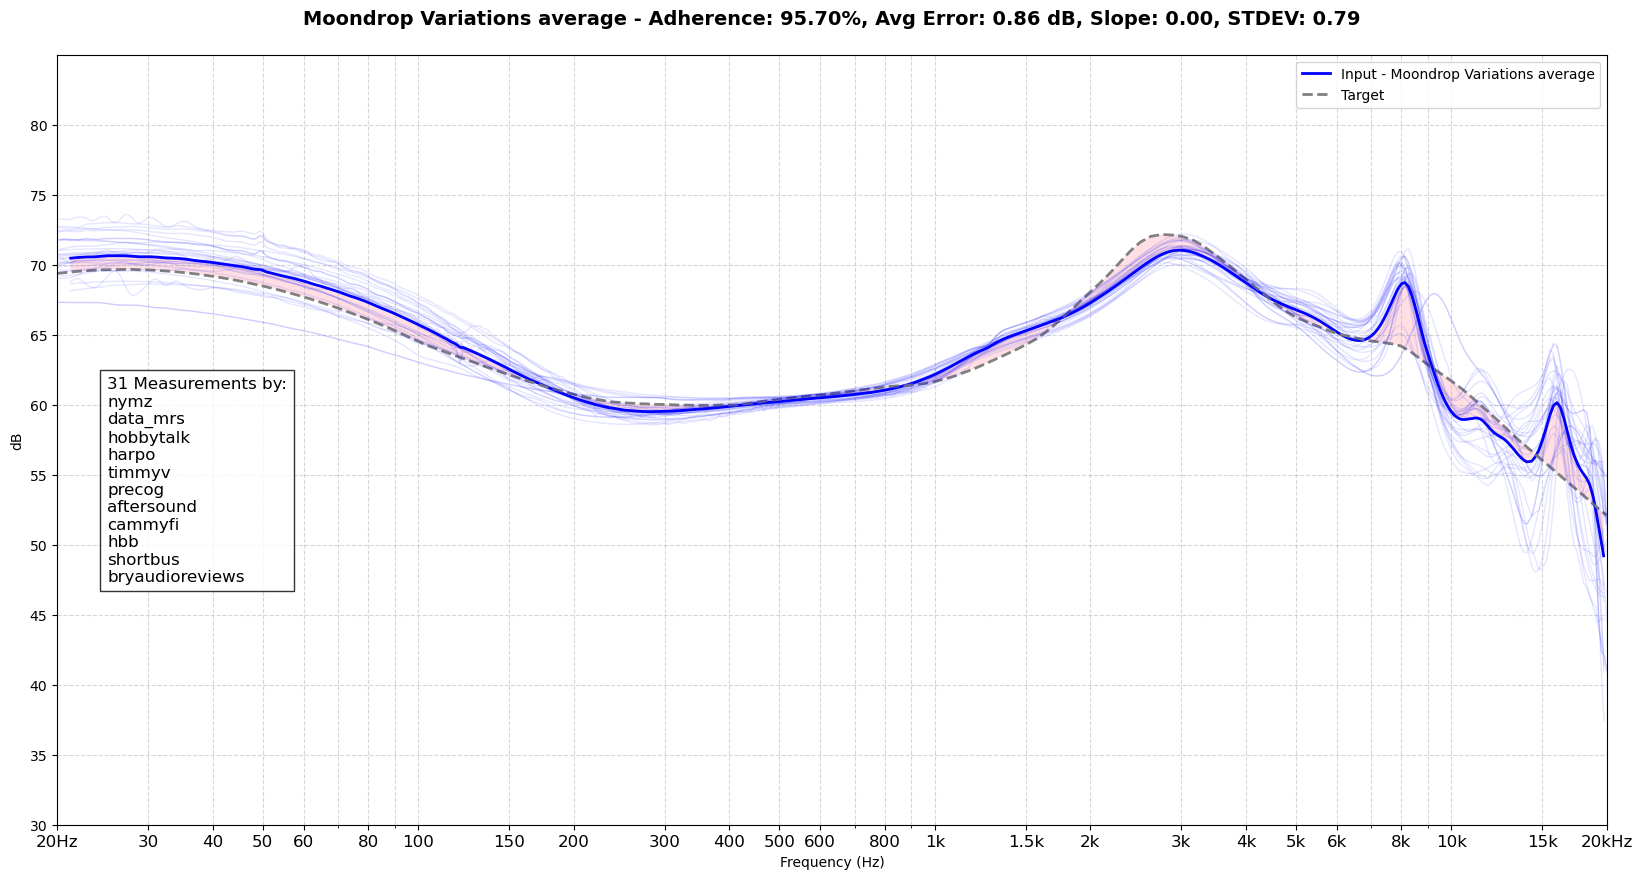

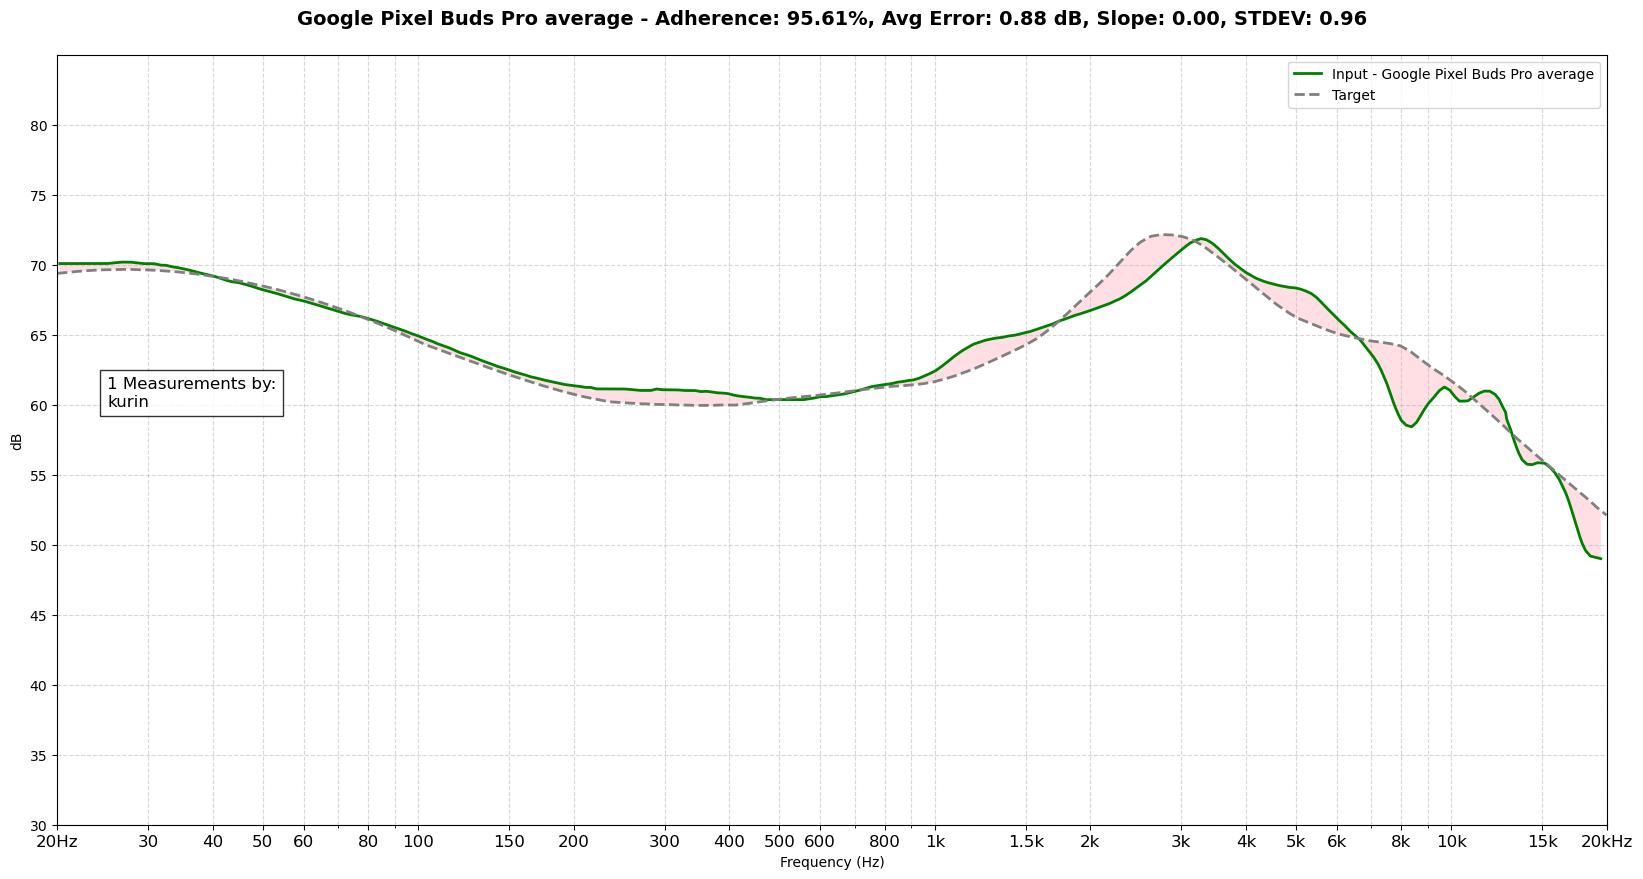

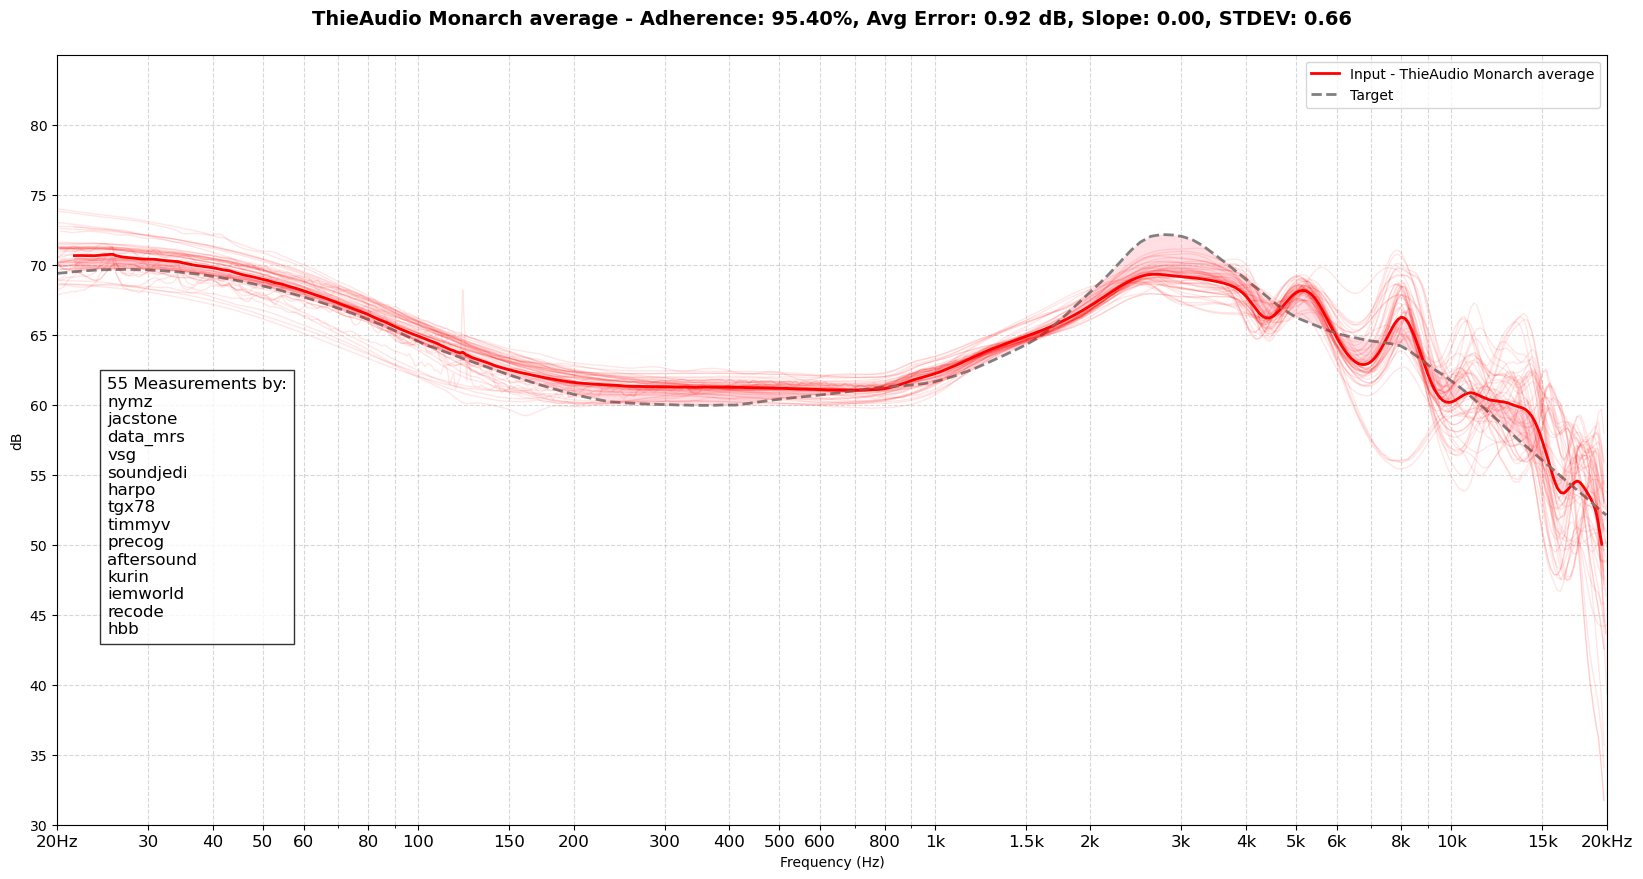

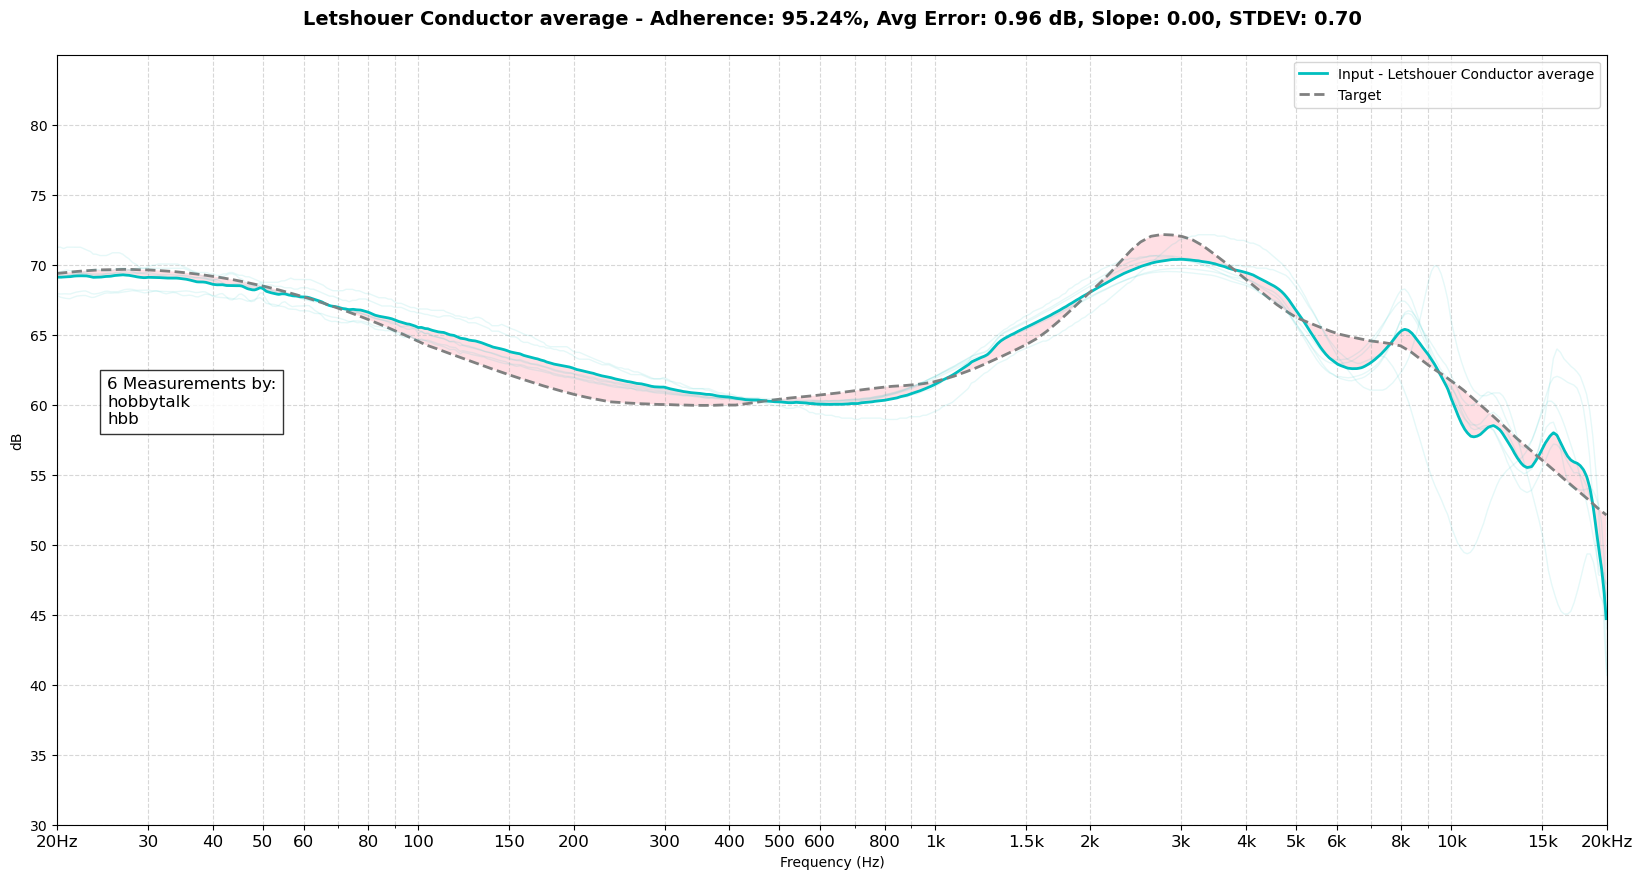

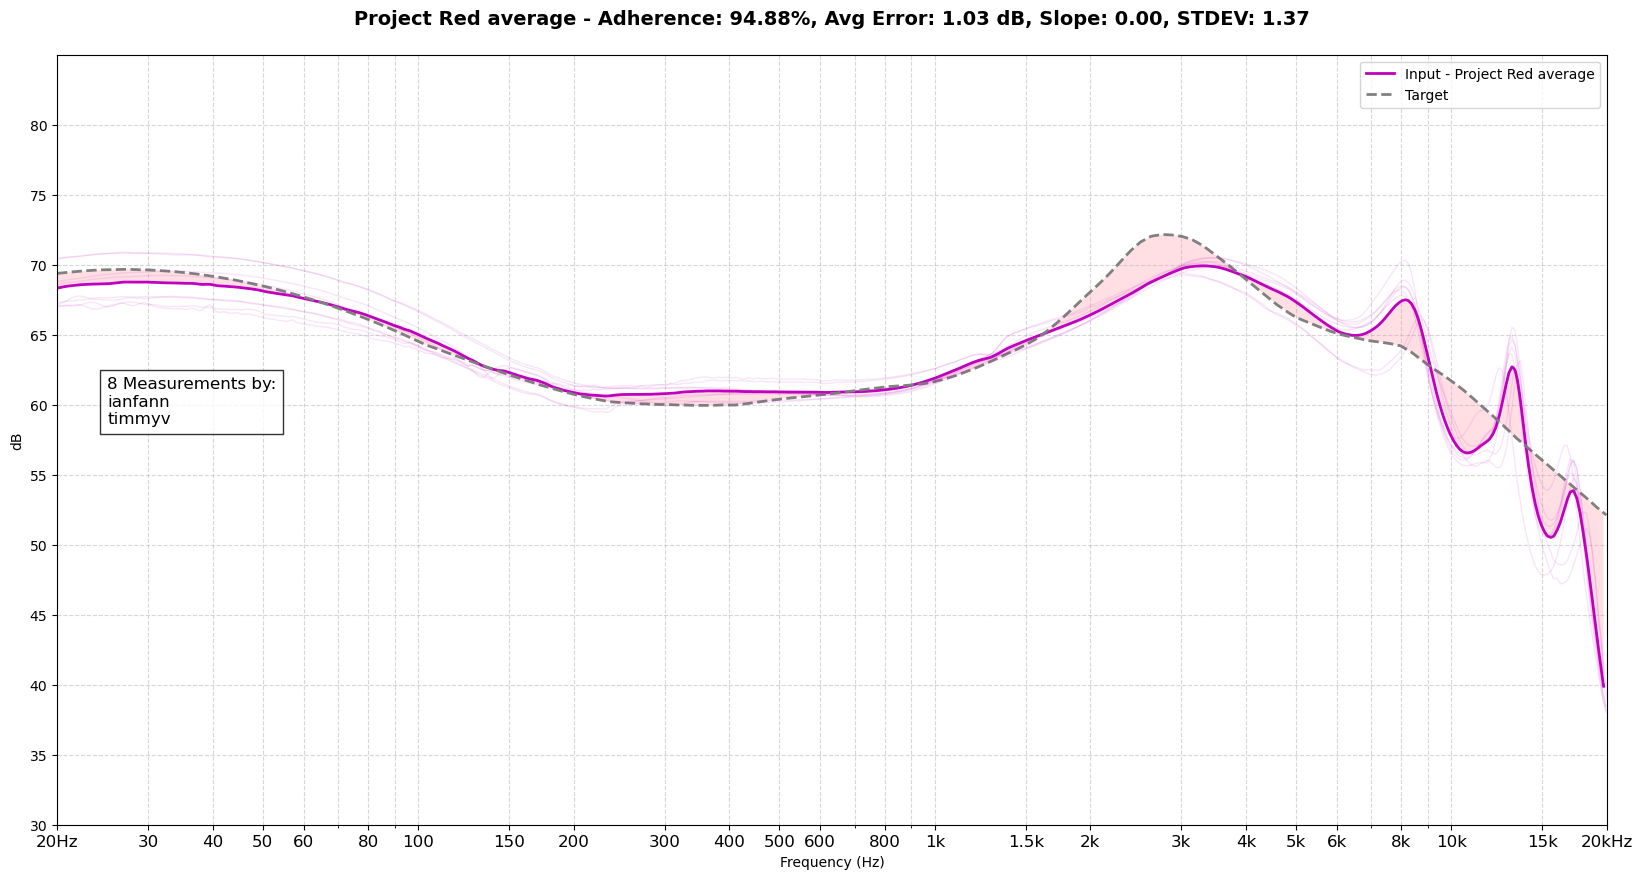

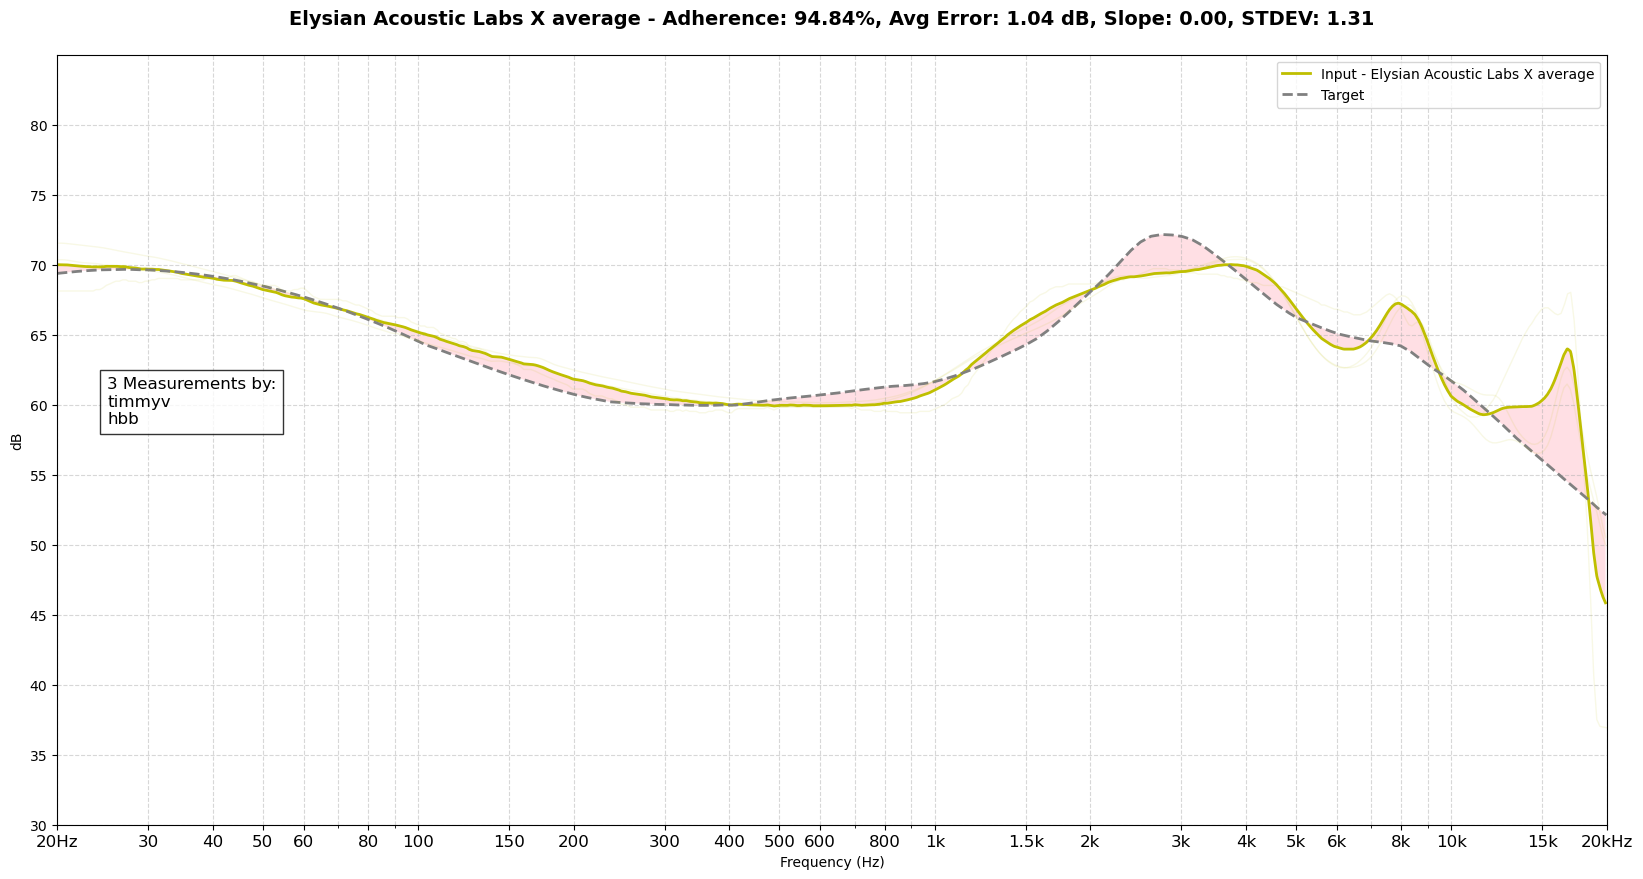

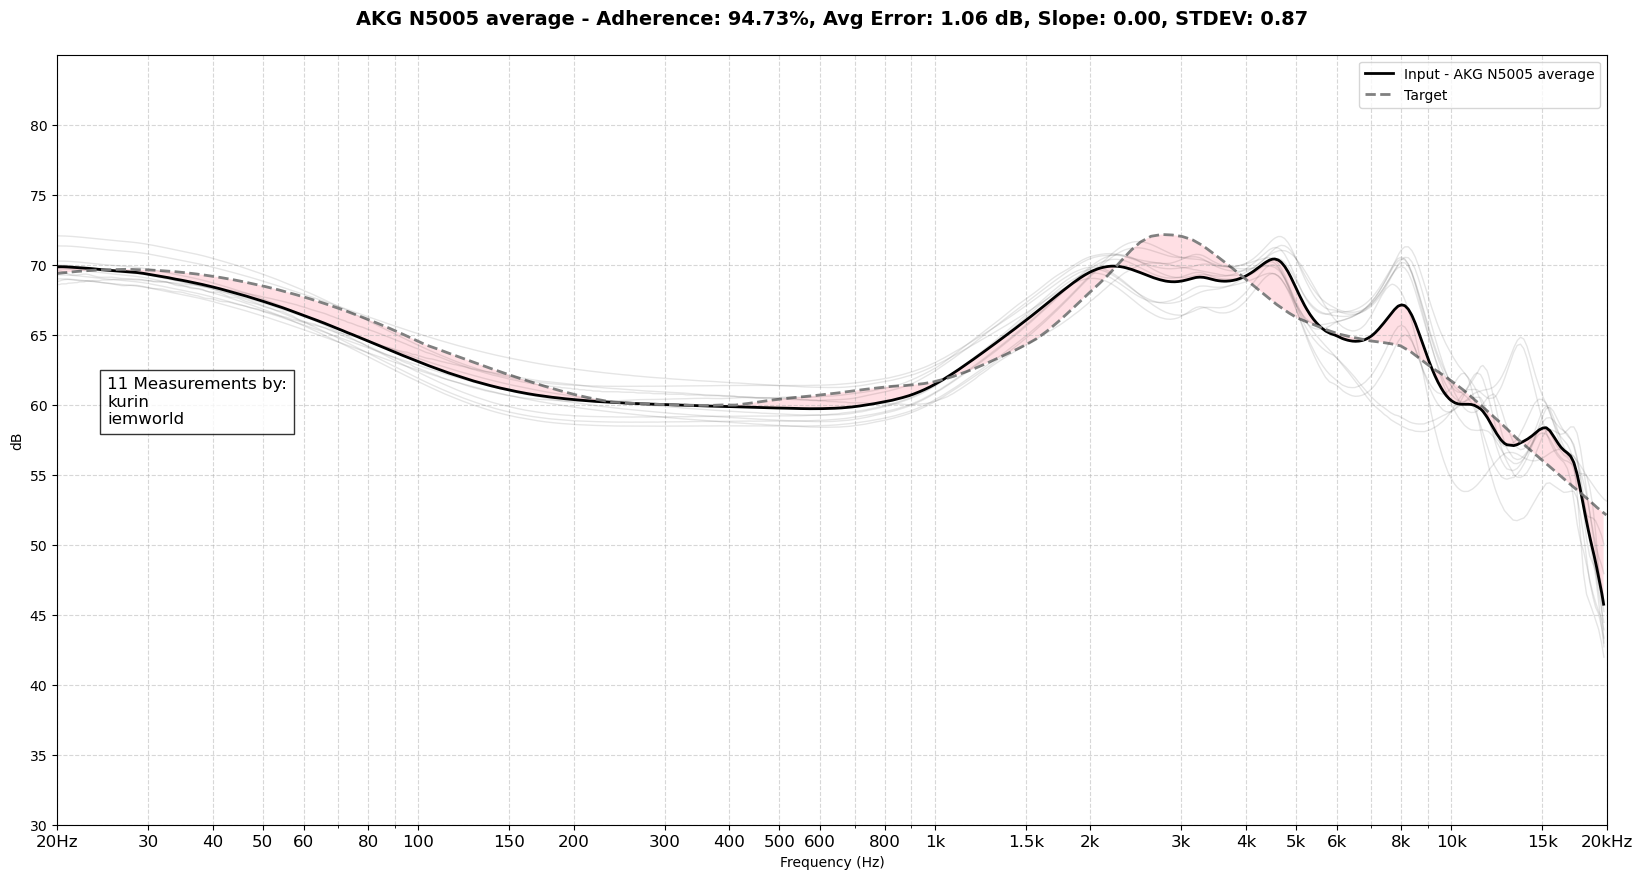

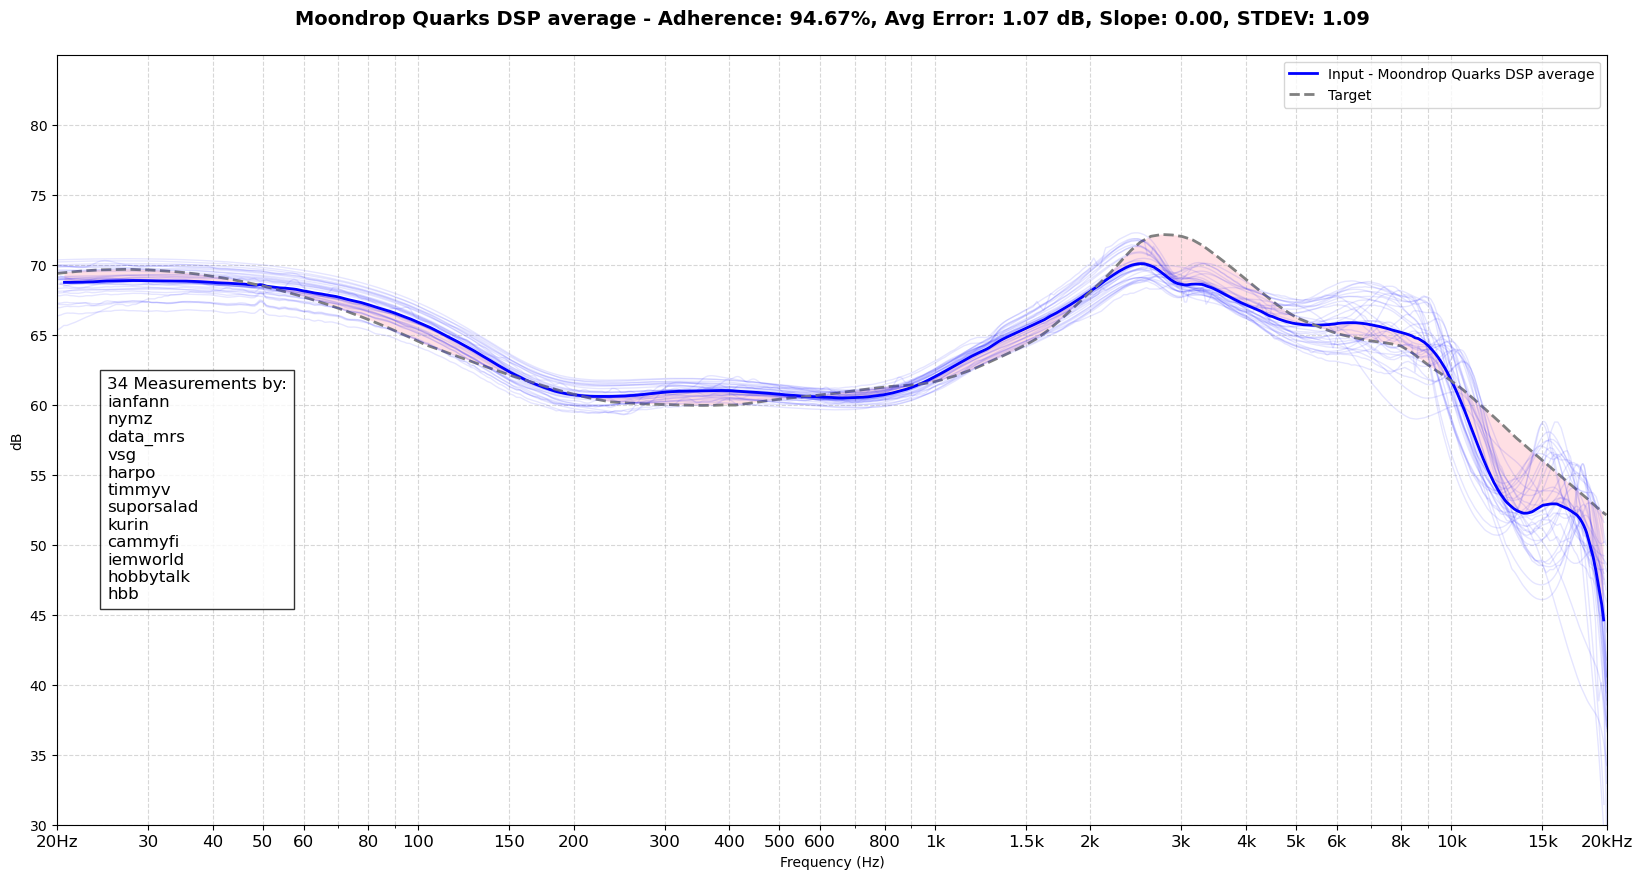

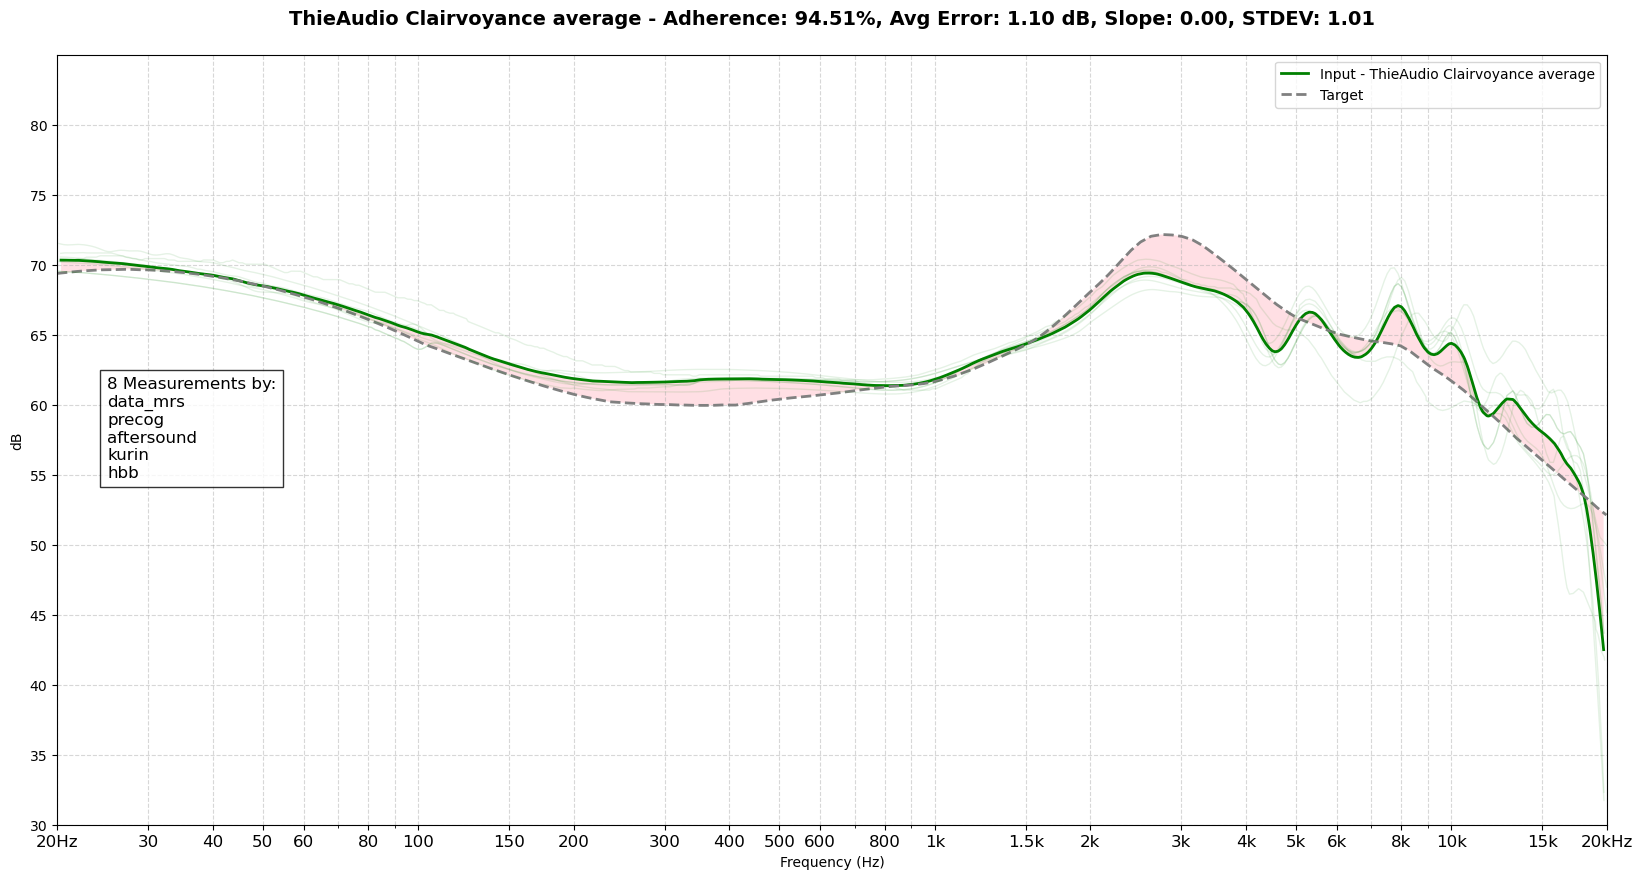

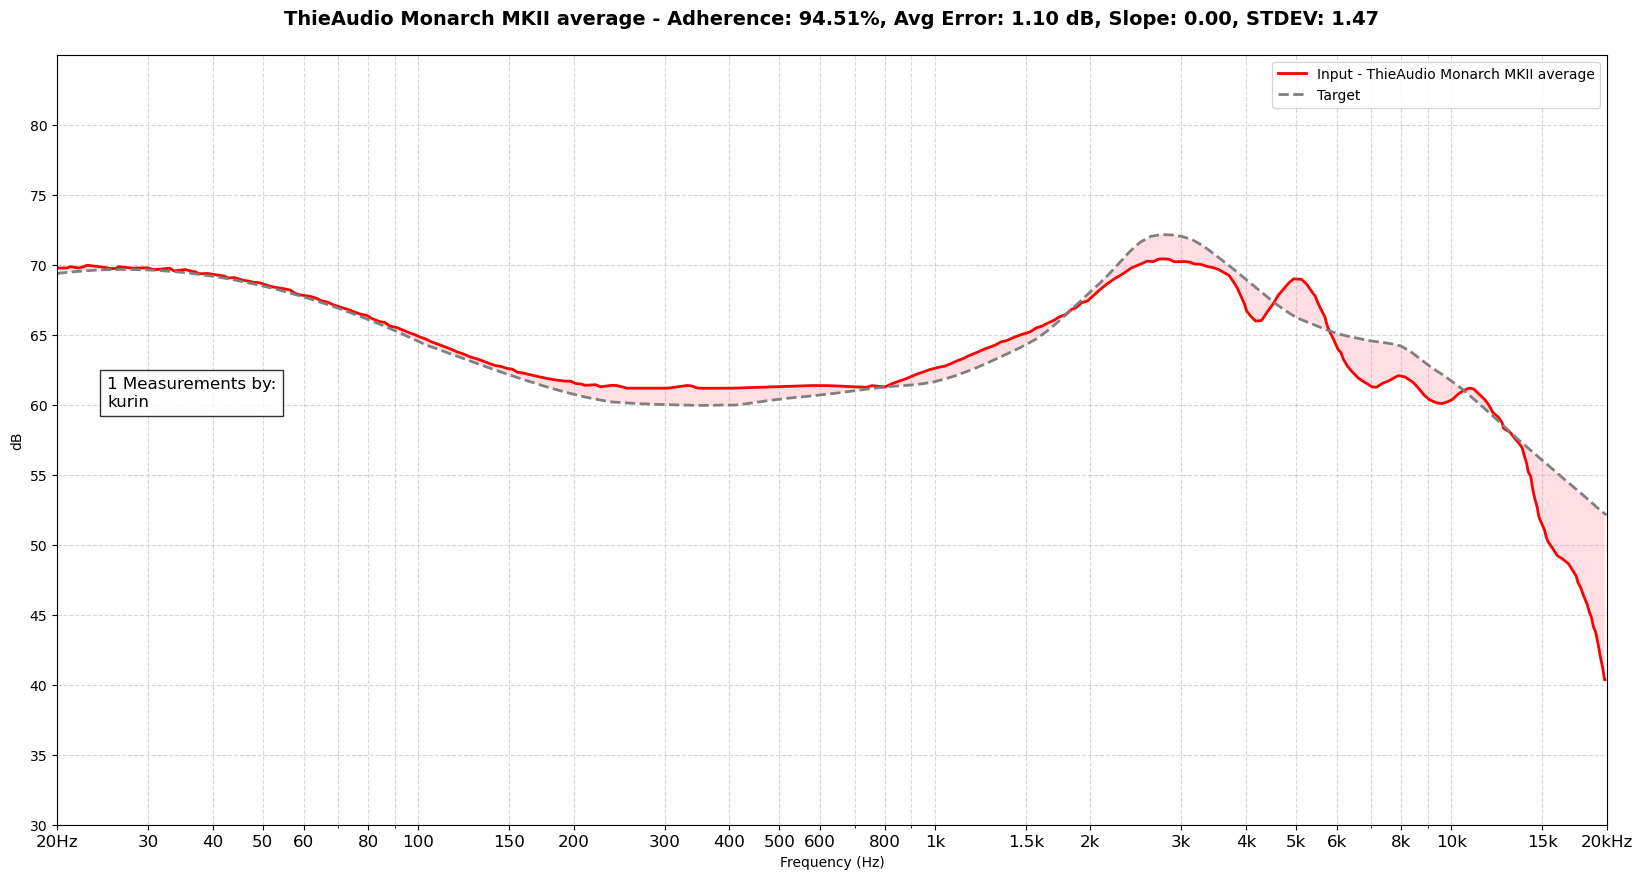

In [43]:
# Color cycle
color_cycle = itertools.cycle(['b', 'g', 'r', 'c', 'm', 'y', 'k'])

# Loop through the DataFrame and plot each IEM
for index, row in df_sorted.iterrows():
    if index >= 10:
        break
    
    iem_name = row['IEM Name']
    average_file_path = row['Average File Path']
    reviewers = row['Reviewers']
    preference_percentage = row['Preference %']
    avg_error = row['Average Error (dB)']
    slope_error = row['Slope of Error']
    stdev_error = row['STDEV of Error']
    num_files = row['Number of Files']
    file_paths = row['File Paths']
    data_list = read_data_files(file_paths)
    color = next(color_cycle)

    plot_preference(average_file_path, 'input/Objectively Neutral IE Target.csv', preference_percentage, num_files, avg_error, slope_error, stdev_error, color, reviewers, data_list)
